# Hand Sign Recognition with CNN

Using a Convolutional Neural Network for recognizing hand signs.

_PyTorch implementation of the assignment of Course 4 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that can load the images from the given `.h5` files. The files contain:

- 1080 training examples
- 120 testing examples
- each image is of size: (64, 64, 3)
- there are 6 different signs (numbers 0 to 5)

In [4]:
class HandSignsDataset(Dataset):
    def __init__(self, train, transform=None):
        prefix = 'train' if train else 'test'
        dataset = h5py.File(f'data/{prefix}_signs.h5', 'r')

        self.X = np.array(dataset[f'{prefix}_set_x'][:])
        self.y = np.array(dataset[f'{prefix}_set_y'][:])
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.transform(self.X[idx, :]) if self.transform else self.X[idx, :]
        y = self.y[idx]

        return X, y

We can now create training and test sets. We use `ToTensor()` to convert the images to a PyTorch tensor with shape channels x height x width, and with pixel values rescaled from [0, 255] to [0, 1].

In [5]:
training = DataLoader(HandSignsDataset(train=True, transform=transforms.ToTensor()), batch_size=64, shuffle=True, num_workers=4)
testing = DataLoader(HandSignsDataset(train=False, transform=transforms.ToTensor()), batch_size=64, shuffle=True, num_workers=4)

Let's look at some examples from the training set.

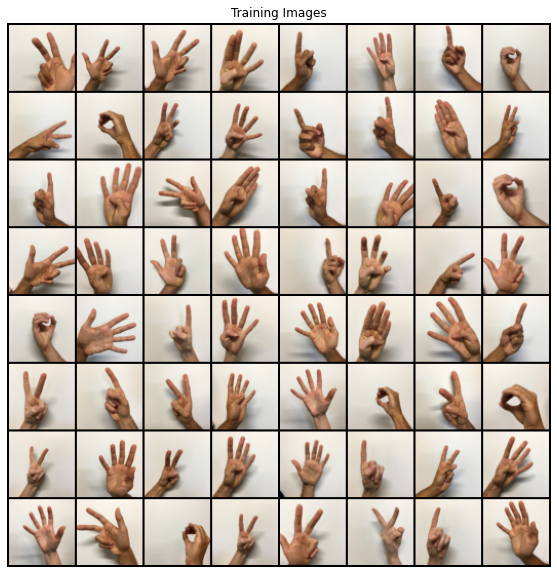

In [6]:
batch = next(iter(training))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Training Images')
# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(vutils.make_grid(batch[0], padding=2, normalize=True), (1, 2, 0)));

## Model

We'll use a Convolutional Neural Network as follows:

- Hidden Layer 1: Conv -> ReLU
  - in_channels=3 (RBG)
  - filters=8
  - filter_size=4
  - stride=1
  - padding=same
- Hidden Layer 2: MaxPool
  - filter_size=8
  - stride=8
  - padding=same
- Hidden Layer 3: Conv -> ReLU
  - in_channels=8
  - filters=16
  - filter_size=2
  - stride=1
  - padding=same
- Hidden Layer 4: MaxPool
  - filter_size=4
  - stride=4
  - padding=same
- Flatten Layer: Convert volume of size 16 x 64 x 64 to vectors of size 65,536
- Output Layer: Linear -> Softmax with 6 units

To compute the padding needed for _same_ convolutions we can use the following formula (derived from the formula for the output height/width):

$$p = \frac{(h-1) \cdot s - h + f}{2}$$

where $h$ is the height (can also be substituted for the width), $s$ is the stride and $f$ is the filter size.

_See: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d_

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            # Hidden Layer 1
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # Hidden Layer 2
            # We need to add a padding layer because the padding is larger than the kernel size which causes `MaxPool2d` to fail
            nn.ZeroPad2d(padding=224),
            # We use `ceil_mode=True` to keep the original size of 64 x 64, otherwise it gets floored to 63 x 63
            nn.MaxPool2d(kernel_size=8, stride=8, padding=0, ceil_mode=True),
            # Hidden Layer 3
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            # Hidden Layer 4
            # We need to add a padding layer because the padding is larger than the kernel size which causes `MaxPool2d` to fail
            nn.ZeroPad2d(padding=96),
            # We use `ceil_mode=True` to keep the original size of 64 x 64, otherwise it gets floored to 63 x 63
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0, ceil_mode=True),
            nn.Flatten(),
            # Output layer
            nn.Linear(in_features=65536, out_features=6),
            # We don't add the softmax activation function here because it will be combined with the loss function
        )

    def forward(self, input):
        return self.net(input)

In [8]:
model = Model()
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ZeroPad2d(padding=(224, 224, 224, 224), value=0.0)
    (3): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=True)
    (4): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): ZeroPad2d(padding=(96, 96, 96, 96), value=0.0)
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
    (8): Flatten()
    (9): Linear(in_features=65536, out_features=6, bias=True)
  )
)


## Optimization

We'll use Adam for training the model with the cross-entropy loss.

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Training

Time to train the model!

In [10]:
# Training configuration
epochs = 100

[0/100]	Loss: 1.8086577653884888
[5/100]	Loss: 1.785032033920288
[10/100]	Loss: 1.6338635683059692
[15/100]	Loss: 1.2506941556930542
[20/100]	Loss: 1.0575541257858276
[25/100]	Loss: 0.8950234651565552
[30/100]	Loss: 0.7989223599433899
[35/100]	Loss: 0.722318172454834
[40/100]	Loss: 0.6742015480995178
[45/100]	Loss: 0.6071009635925293
[50/100]	Loss: 0.5632289052009583
[55/100]	Loss: 0.5259853601455688
[60/100]	Loss: 0.4764086902141571
[65/100]	Loss: 0.46567559242248535
[70/100]	Loss: 0.41491639614105225
[75/100]	Loss: 0.3903740644454956
[80/100]	Loss: 0.37263378500938416
[85/100]	Loss: 0.3685451149940491
[90/100]	Loss: 0.3340820074081421
[95/100]	Loss: 0.31263604760169983


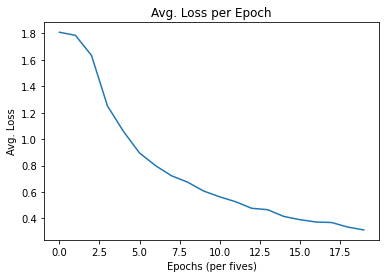

In [11]:
# Main training loop
model = model.to(device)
total_losses = []

for epoch in range(epochs):
    losses = []

    for samples, targets in training:
        optimizer.zero_grad()
        samples = samples.to(device)
        targets = targets.to(device)

        output = model(samples)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

    if epoch % 5 == 0:
        total_losses.append(np.mean(losses))
        print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses per tens of epochs
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs (per fives)')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can evaluate it against the testing set.

In [12]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

accuracies = []

# Main inference loop
for samples, targets in testing:
    output = model(samples.to(device))

    output = output.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    
    # Convert to the actual class predictions by finding the most confident label
    predictions = np.argmax(output, axis=1)

    # Remove extra dimension, i.e. flatten as vector
    predictions = np.squeeze(predictions)
    targets = np.squeeze(targets)

    # Since now we have actual classes we can evaluate using accuracy
    accuracies.append(np.mean(predictions == targets))

print(f'Accuracy = {np.mean(accuracies)}')

Accuracy = 0.8415178571428572


Finally, we can look at an example from the testing set and see what our model recognizes it as.

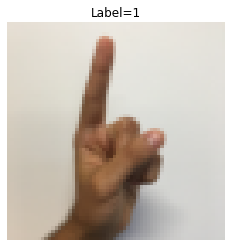

In [13]:
batch = next(iter(testing))
sample = batch[0][23]
# Make sure to add the batch size dimension to the sample where batch size = 1
sample = sample.unsqueeze(0)

# Compute the label
output = model(sample.to(device))
label = np.argmax(output.detach().cpu().numpy(), axis=1)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.title(f'Label={np.squeeze(label)}')
# We need to remove the batch size dimension and swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(np.squeeze(sample), (1, 2, 0)));